In [56]:
# Enable the inline backend for usage with the IPython Notebook
%matplotlib inline

In [57]:
# import necessary packages
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

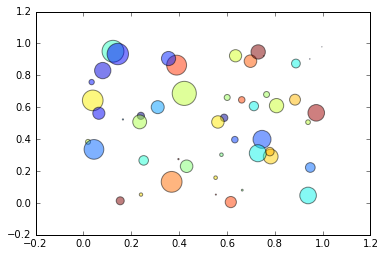

In [58]:
"""
1. Simple demo of a scatter plot
"""
N = 50
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = np.pi * (15 * np.random.rand(N))**2  # 0 to 15 point radiuses
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()

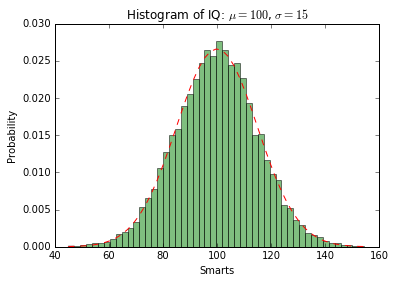

In [59]:
"""
2. Demo of the histogram (hist) function with a few features.
"""
# example data
mu = 100  # mean of distribution
sigma = 15  # standard deviation of distribution
x = mu + sigma * np.random.randn(10000)
num_bins = 50
# the histogram of the data
n, bins, patches = plt.hist(x, num_bins, normed=1, facecolor='green', alpha=0.5)
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title(r'Histogram of IQ: $\mu=100$, $\sigma=15$')
# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

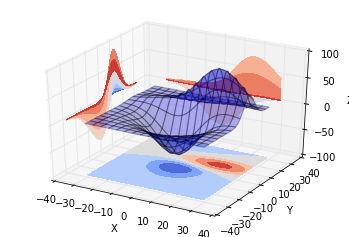

In [60]:
"""
3. This demo depends on new features added to contourf3d.
"""
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)
ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
cset = ax.contourf(X, Y, Z, zdir='z', offset=-100, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)

ax.set_xlabel('X')
ax.set_xlim(-40, 40)
ax.set_ylabel('Y')
ax.set_ylim(-40, 40)
ax.set_zlabel('Z')
ax.set_zlim(-100, 100)

plt.show()

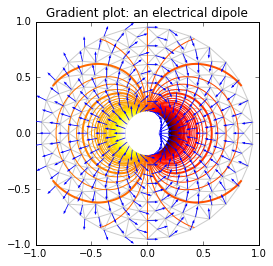

In [61]:
"""
4. Demonstrates computation of gradient with matplotlib.tri.CubicTriInterpolator.
"""
from matplotlib.tri import Triangulation, UniformTriRefiner,\
    CubicTriInterpolator
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import math


#-----------------------------------------------------------------------------
# Electrical potential of a dipole
#-----------------------------------------------------------------------------
def dipole_potential(x, y):
    """ The electric dipole potential V """
    r_sq = x**2 + y**2
    theta = np.arctan2(y, x)
    z = np.cos(theta)/r_sq
    return (np.max(z) - z) / (np.max(z) - np.min(z))


#-----------------------------------------------------------------------------
# Creating a Triangulation
#-----------------------------------------------------------------------------
# First create the x and y coordinates of the points.
n_angles = 30
n_radii = 10
min_radius = 0.2
radii = np.linspace(min_radius, 0.95, n_radii)

angles = np.linspace(0, 2*math.pi, n_angles, endpoint=False)
angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1)
angles[:, 1::2] += math.pi/n_angles

x = (radii*np.cos(angles)).flatten()
y = (radii*np.sin(angles)).flatten()
V = dipole_potential(x, y)

# Create the Triangulation; no triangles specified so Delaunay triangulation
# created.
triang = Triangulation(x, y)

# Mask off unwanted triangles.
xmid = x[triang.triangles].mean(axis=1)
ymid = y[triang.triangles].mean(axis=1)
mask = np.where(xmid*xmid + ymid*ymid < min_radius*min_radius, 1, 0)
triang.set_mask(mask)

#-----------------------------------------------------------------------------
# Refine data - interpolates the electrical potential V
#-----------------------------------------------------------------------------
refiner = UniformTriRefiner(triang)
tri_refi, z_test_refi = refiner.refine_field(V, subdiv=3)

#-----------------------------------------------------------------------------
# Computes the electrical field (Ex, Ey) as gradient of electrical potential
#-----------------------------------------------------------------------------
tci = CubicTriInterpolator(triang, -V)
# Gradient requested here at the mesh nodes but could be anywhere else:
(Ex, Ey) = tci.gradient(triang.x, triang.y)
E_norm = np.sqrt(Ex**2 + Ey**2)

#-----------------------------------------------------------------------------
# Plot the triangulation, the potential iso-contours and the vector field
#-----------------------------------------------------------------------------
plt.figure()
plt.gca().set_aspect('equal')
plt.triplot(triang, color='0.8')

levels = np.arange(0., 1., 0.01)
cmap = cm.get_cmap(name='hot', lut=None)
plt.tricontour(tri_refi, z_test_refi, levels=levels, cmap=cmap,
               linewidths=[2.0, 1.0, 1.0, 1.0])
# Plots direction of the electrical vector field
plt.quiver(triang.x, triang.y, Ex/E_norm, Ey/E_norm,
           units='xy', scale=10., zorder=3, color='blue',
           width=0.007, headwidth=3., headlength=4.)

plt.title('Gradient plot: an electrical dipole')
plt.show()

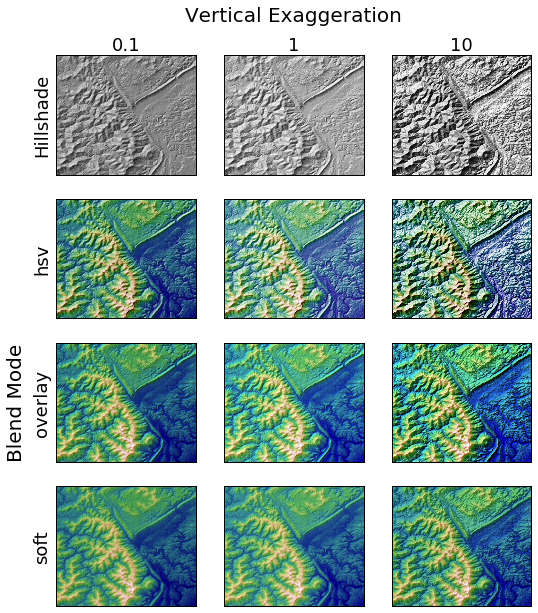

In [62]:
"""
5. Demonstrates the visual effect of varying blend mode and vertical exaggeration on "hillshaded" plots.
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cbook import get_sample_data
from matplotlib.colors import LightSource

dem = np.load(get_sample_data('jacksboro_fault_dem.npz'))
z = dem['elevation']

#-- Optional dx and dy for accurate vertical exaggeration --------------------
# If you need topographically accurate vertical exaggeration, or you don't want
# to guess at what *vert_exag* should be, you'll need to specify the cellsize
# of the grid (i.e. the *dx* and *dy* parameters).  Otherwise, any *vert_exag*
# value you specify will be realitive to the grid spacing of your input data
# (in other words, *dx* and *dy* default to 1.0, and *vert_exag* is calculated
# relative to those parameters).  Similarly, *dx* and *dy* are assumed to be in
# the same units as your input z-values.  Therefore, we'll need to convert the
# given dx and dy from decimal degrees to meters.
dx, dy = dem['dx'], dem['dy']
dy = 111200 * dy
dx = 111200 * dx * np.cos(np.radians(dem['ymin']))
#-----------------------------------------------------------------------------

# Shade from the northwest, with the sun 45 degrees from horizontal
ls = LightSource(azdeg=315, altdeg=45)
cmap = plt.cm.gist_earth

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(8, 9))
plt.setp(axes.flat, xticks=[], yticks=[])

# Vary vertical exaggeration and blend mode and plot all combinations
for col, ve in zip(axes.T, [0.1, 1, 10]):
    # Show the hillshade intensity image in the first row
    col[0].imshow(ls.hillshade(z, vert_exag=ve, dx=dx, dy=dy), cmap='gray')

    # Place hillshaded plots with different blend modes in the rest of the rows
    for ax, mode in zip(col[1:], ['hsv', 'overlay', 'soft']):
        rgb = ls.shade(z, cmap=cmap, blend_mode=mode,
                       vert_exag=ve, dx=dx, dy=dy)
        ax.imshow(rgb)

# Label rows and columns
for ax, ve in zip(axes[0], [0.1, 1, 10]):
    ax.set_title('{0}'.format(ve), size=18)
for ax, mode in zip(axes[:, 0], ['Hillshade', 'hsv', 'overlay', 'soft']):
    ax.set_ylabel(mode, size=18)

# Group labels...
axes[0, 1].annotate('Vertical Exaggeration', (0.5, 1), xytext=(0, 30),
                    textcoords='offset points', xycoords='axes fraction',
                    ha='center', va='bottom', size=20)
axes[2, 0].annotate('Blend Mode', (0, 0.5), xytext=(-30, 0),
                    textcoords='offset points', xycoords='axes fraction',
                    ha='right', va='center', size=20, rotation=90)
fig.subplots_adjust(bottom=0.05, right=0.95)

plt.show()